# Real-time auto-tagging inference with essentia-tensorflow and souncard

In [1]:
%matplotlib nbagg

import numpy as np
import matplotlib.pyplot as plt
import soundcard as sc

from struct import unpack
from IPython import display

from essentia.streaming import *
from essentia import Pool, run, array, reset

In [2]:
# model parameters
modelName = 'msd-musicnn.pb'
inputLayer = 'model/Placeholder'
outputLayer = 'model/Sigmoid'
labels = ['rock','pop','alternative','indie','electronic','female vocalists','dance','00s','alternative rock','jazz','beautiful','metal','chillout','male vocalists','classic rock','soul','indie rock','Mellow','electronica','80s','folk','90s','chill','instrumental','punk','oldies','blues','hard rock','ambient','acoustic','experimental','female vocalist','guitar','Hip-Hop','70s','party','country','easy listening','sexy','catchy','funk','electro','heavy metal','Progressive rock','60s','rnb','indie pop','sad','House','happy']
nLabels = len(labels)

sampleRate = 16000
frameSize = 512 
hopSize = 256
numberBands = 96

# analysis parameters
patchSize = 64
displaySize = 10

bufferSize = patchSize * hopSize

##  Instantiate and connect the algorithms 

In [3]:
buffer = np.zeros(bufferSize, dtype='float32')

vimp = VectorInput(buffer)

fc = FrameCutter(frameSize=frameSize, hopSize=hopSize)

tim = TensorflowInputMusiCNN()

vtt = VectorRealToTensor(shape=[1, 1, patchSize, numberBands],
                         lastPatchMode='discard')

ttp = TensorToPool(namespace=inputLayer)

tfp = TensorflowPredict(graphFilename=modelName,
                        inputs=[inputLayer],
                        outputs=[outputLayer])

ptt = PoolToTensor(namespace=outputLayer)

ttv = TensorToVectorReal()

pool = Pool()

In [4]:
vimp.data   >> fc.signal
fc.frame    >> tim.frame
tim.bands   >> vtt.frame
tim.bands   >> (pool, 'melbands')
vtt.tensor  >> ttp.tensor
ttp.pool    >> tfp.poolIn
tfp.poolOut >> ptt.pool
ptt.tensor  >> ttv.tensor
ttv.frame   >> (pool, outputLayer)

## Callback to update the plots

In [5]:
from scipy.special import softmax

In [6]:
def callback(data):
    # update audio buffer
    buffer[:] = array(unpack('f' * bufferSize, data))

    # generate predictions
    reset(vimp)
    run(vimp)

    # update mel and activation buffers
    melBuffer[:] = np.roll(melBuffer, -patchSize)
    melBuffer[:, -patchSize:] = pool['melbands'][-patchSize:,:].T
    img_mel.set_data(melBuffer)
    
    actBuffer[:] = np.roll(actBuffer, -1)
    actBuffer[:, -1] = softmax(20 * pool['model/Sigmoid'][-1,:].T)
    img_act.set_data(actBuffer)

    # update plots
    f.canvas.draw()

## Prcess from a file

<IPython.core.display.Javascript object>


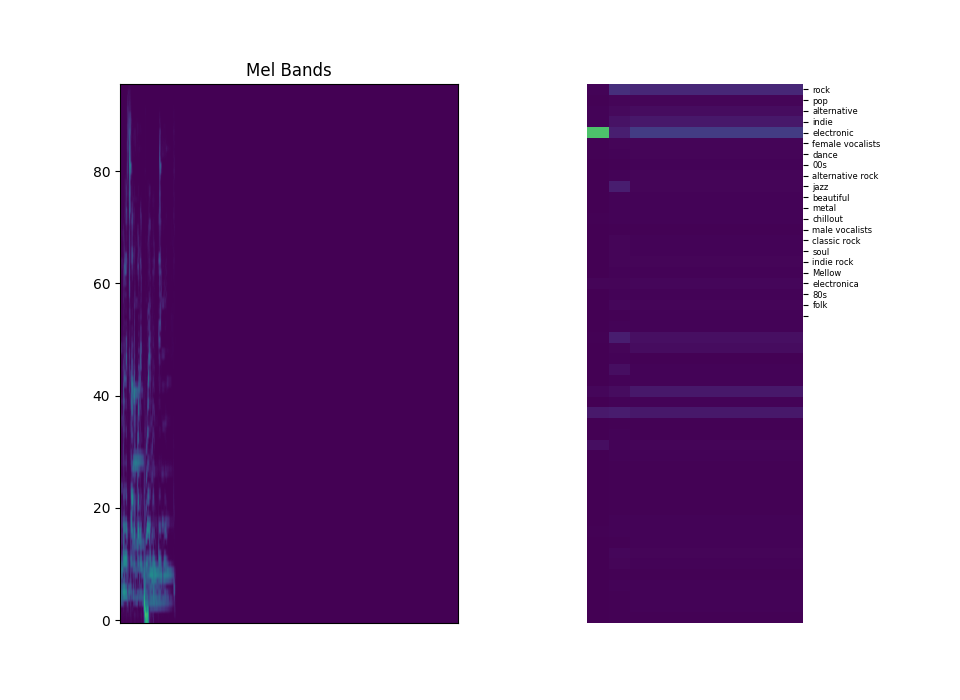

KeyboardInterrupt: 

In [7]:
# initialize plot buffers
melBuffer = np.zeros([numberBands, patchSize * displaySize])
actBuffer = np.zeros([nLabels, displaySize])

# reset storage
pool.clear()

# initialize plots
f, ax = plt.subplots(1, 2, figsize=[9.6, 7])
f.canvas.draw()

ax[0].set_title('Mel Bands')
img_mel = ax[0].imshow(melBuffer, aspect='auto',
                       origin='lower', vmin=0, vmax=6)
ax[0].set_xticks([])

ax[1].set_title('Activations')
img_act = ax[1].matshow(actBuffer, aspect='0.5', vmin=0, vmax=1)
ax[1].set_xticks([])
ax[1].yaxis.set_ticks_position('right')
plt.yticks(np.arange(nLabels), labels, fontsize=6)

# capture and process the speakers loopback
with sc.all_microphones(include_loopback=True)[0].recorder(samplerate=sampleRate) as mic:
    while True:
        callback(mic.record(numframes=bufferSize).mean(axis=1))